### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## План работы:
___
##### [Шаг 1. Загрузка данных и ознакомление](#1-link)

##### [Шаг 2. Подготовка объединенных данных](#2-link)
* [Анализ пересечений групп одновременно проводимых тестов](#3-link)

##### [Шаг 3. Исследовательский анализ](#4-link)
* [Распределение количества событий на пользователя](#5-link)
* [Наличие в выборках одних и тех же пользователей](#6-link)
* [Распределение числа событий по дням](#7-link)
* [Конверсия product_page по группам](#8-link)
* [Относительный прирост конверсии product_page по группам](#9-link)
* [Конверсия product_cart по группам](#10-link)
* [Относительный прирост конверсии product_cart по группам](#11-link)
* [Конверсия purchase по группам](#12-link)
* [Относительный прирост конверсии purchase по группам](#13-link)
* [Выручка в разрезе групп](#14-link)
* [Средний чек в разрезе групп](#15-link)
* [Отношение среднего чека групп](#16-link)


##### [Шаг 4. Статистическая значимость различий в конверсии между группами](#17-link)
##### [Шаг 5. Вывод](#18-link)

# Шаг 1. Загрузка данных и ознакомление<a id='1-link'></a>

In [64]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy import stats as st
import math as mth

In [65]:
calendar = pd.read_csv(r'C:\ab_project_marketing_events.csv')
new_users = pd.read_csv(r'C:\final_ab_new_users.csv')
new_users_events = pd.read_csv(r'C:\final_ab_events.csv')  
test_users = pd.read_csv(r'C:\final_ab_participants.csv')

In [66]:
calendar.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Период проведения теста 07.12.2020 - 04.01.2021, в данный интервал попадает Christmas&New Year Promo, которые проходит в период с 25.12.2020 по 03.01.2021.

Если итоговые показатели покажут значительные флуктуации в этот интервал - оценим влияние, допустив, что промоакция в совокупности с новой системой оказала тот или иной эффект

In [4]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [5]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
new_users_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [7]:
new_users_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Информация о группах тестирования

In [8]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [9]:
test_users.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
test_users.query('ab_test == "recommender_system_test"').shape

(6701, 3)

# Шаг 2. Подготовка объединенных данных<a id='2-link'></a>

Объединим данные о пользователях и их действиях в один датасет, для дальнейшего анализа результатов тестирования, 

In [11]:
new_user_summary = new_users_events.merge(new_users, how='left', left_on=['user_id'], right_on=['user_id'])

Количество событий, осуществленное пользователями, которые зарегистрировались после 7 декабря 2020

In [12]:
new_user_summary.shape

(440317, 7)

Количество пользователей, информация о действия которых записана в датасете

In [13]:
new_user_summary['user_id'].nunique()

58703

Количество изменилось, т.к. не все зарегистрировавшиеся пользователи вообще заходили в приложение

Присвоим корректные типы данных столбцам с информацией о времени

In [14]:
new_user_summary['first_date'] = new_user_summary['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [15]:
new_user_summary['event_dt'] = new_user_summary['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [16]:
new_user_summary['event_day'] = new_user_summary['event_dt'].astype('datetime64[D]')

### Анализ пересечений групп одновременно проводимых тестов<a id='3-link'></a>

Группа А в обоих тестах видит исходный вариант приложения, группа B - измененный, соответственно исключим пересечения в группе B для исключения влияния их данных на результаты теста

In [17]:
test_groups_A = test_users.query('ab_test == "recommender_system_test" and group =="A"')

In [18]:
test_groups_B = test_users.query('ab_test == "recommender_system_test" and group =="B"')
test_groups_B.shape

(2877, 3)

In [19]:
interface_eu_test_groups_A = test_users.query('ab_test == "interface_eu_test" and group =="A"')
interface_eu_test_groups_A.shape

(5831, 3)

In [20]:
interface_eu_test_groups_B = test_users.query('ab_test == "interface_eu_test" and group =="B"')
interface_eu_test_groups_B.shape

(5736, 3)

In [21]:
test_groups_A['user_id'].isin(interface_eu_test_groups_A['user_id']).sum()

482

In [22]:
test_groups_B['user_id'].isin(interface_eu_test_groups_B['user_id']).sum()

344

In [23]:
test_groups_A['user_id'].isin(interface_eu_test_groups_A['user_id']).sum()/len(test_groups_A['user_id'])

0.1260460251046025

In [24]:
test_groups_B['user_id'].isin(interface_eu_test_groups_B['user_id']).sum()/len(test_groups_B['user_id'])

0.11956899548140425

Доля пересекающихся аудиторий тестирований в группах сопоставимы, исключение из тестирование необязательно

Распределение по группам тестирования

In [25]:
test_group = test_users.query('ab_test == "recommender_system_test"')

Создадим датасет с действиями пользователей, участвующих в тесте

In [26]:
fin_df_v1 = new_user_summary.merge(test_group, how = "left", left_on = 'user_id', right_on= 'user_id')
fin_df_v1 = fin_df_v1.query('group == "A" or group == "B"')
del fin_df_v1['ab_test']
fin_df_v1.shape

(24698, 9)

In [27]:
fin_df_v1.groupby('group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

Заменим пропуски в столбце details

In [28]:
fin_df_v1['details'].fillna('0', inplace=True)

In [29]:
fin_df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 5 to 440289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24698 non-null  object        
 1   event_dt    24698 non-null  datetime64[ns]
 2   event_name  24698 non-null  object        
 3   details     24698 non-null  object        
 4   first_date  24698 non-null  datetime64[ns]
 5   region      24698 non-null  object        
 6   device      24698 non-null  object        
 7   event_day   24698 non-null  datetime64[ns]
 8   group       24698 non-null  object        
dtypes: datetime64[ns](3), object(6)
memory usage: 1.9+ MB


Группировка пользователей исходного датасета по региону

In [30]:
by_region = pd.DataFrame()
by_region['test'] = fin_df_v1.groupby('region')['user_id'].nunique()
by_region['all'] = new_user_summary.groupby('region')['user_id'].nunique()
by_region['share'] = by_region['test'] / by_region['all']
by_region

,test,all,share
region,,,
APAC,45,3126,0.014395
CIS,30,3130,0.009585
EU,3481,43396,0.080215
N.America,119,9051,0.013148


Доля пользователей EU региона составила 8% от новых пользователей EU за этот период, что меньше ожидаемого

Количество пользователей совершавшие действия после регистрации

In [31]:
fin_df_v1['user_id'].nunique()

3675

Проанализируем датасет на аномалии

In [32]:
events_per_user = fin_df_v1.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='count').fillna('0')
events_per_user = events_per_user.reset_index()
events_per_user.head()

event_name,user_id,login,product_cart,product_page,purchase
0,001064FEAAB631A1,3.0,0,3,0
1,0010A1C096941592,4.0,0,4,4
2,00341D8401F0F665,2.0,0,0,0
3,003DF44D7589BBD4,5.0,5,5,0
4,00505E15A9D81546,5.0,0,0,0


Изменим типы данных

In [33]:
events_per_user['product_cart'] = events_per_user['product_cart'].astype('int')
events_per_user['product_page'] = events_per_user['product_page'].astype('int')
events_per_user['purchase'] = events_per_user['purchase'].astype('int')
events_per_user['login'] = events_per_user['login'].astype('int')

Рассмотрим распределение значений 

In [34]:
events_per_user.describe()

event_name,login,product_cart,product_page,purchase
count,3675.000000,3675.000000,3675.000000,3675.000000
mean,3.044898,0.883537,1.885714,0.906395
std,1.253801,1.523733,1.761810,1.523165
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,2.000000,0.000000
75%,4.000000,2.000000,3.000000,2.000000
max,9.000000,9.000000,9.000000,7.000000


Максимальные, минимальные и средние значения по событиям в рамках ожидаемых

## Шаг 3. Исследовательский анализ<a id='4-link'></a>

Посмотрим на общую конверсию событий в разрезе групп

In [35]:
group_A = fin_df_v1.query('group == "A"')
group_B = fin_df_v1.query('group == "B"')

In [36]:
fin_df_v1.groupby('event_name')['user_id'].nunique().sort_values(ascending=False) / fin_df_v1['user_id'].nunique()

event_name
login           1.000000
product_page    0.626667
purchase        0.306939
product_cart    0.293605
Name: user_id, dtype: float64

Общие данные конверсии показывают, что 30% пользователей достигают этапа покупки, что является весьма хорошим результатом.

### Распределение количества событий на пользователя<a id='5-link'></a>

In [37]:
group_A.groupby('user_id')['event_dt'].count().mean()

7.027302511831088

In [38]:
group_B.groupby('user_id')['event_dt'].count().mean()

5.8125

Пользователи группы A в среднем совершают на 1 действие больше

### Наличие в выборках одних и тех же пользователей<a id='6-link'></a>

В каждой группе тестирования 12% пользователей пересекаются с параллельно проводимым тестом. Их равная пропорция позволяет нам не исключать пересечения из анализа.

### Распределение числа событий по дням<a id='7-link'></a>

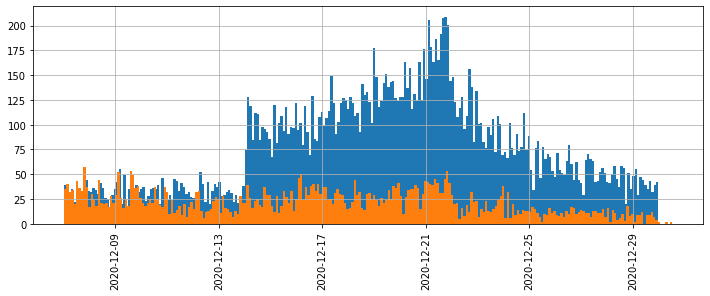

In [39]:
group_A['event_dt'].hist(bins=250, figsize=(12, 4), xrot=90);
group_B['event_dt'].hist(bins=250, figsize=(12, 4), xrot=90);

Количество пользователей групп сильно отличается, однако видно, что в группе А был резки рост количества событий в день.

Финальные тестируемые группы не соответствуют изначальным условиям теста: в финальных группах только 8% EU пользователей от числа новых регистраций, а также общее число тестируемых почти в 2 раза меньше ожидаемого.

Данные о количестве событий в разрезе групп и дат

In [40]:
unique_actions_by_date = fin_df_v1.pivot_table(index = ['event_day', 'group'], columns = 'event_name', values='user_id', aggfunc='nunique').reset_index()
unique_actions_by_date.head()

event_name,event_day,group,login,product_cart,product_page,purchase
0,2020-12-07,A,154.0,35.0,96.0,46.0
1,2020-12-07,B,165.0,46.0,108.0,59.0
2,2020-12-08,A,159.0,37.0,108.0,37.0
3,2020-12-08,B,119.0,34.0,64.0,35.0
4,2020-12-09,A,178.0,50.0,106.0,51.0


Ежедневная конверсия событий 

In [41]:
unique_actions_by_date['conversion_Product_page'] = unique_actions_by_date['product_page']/unique_actions_by_date['login']
unique_actions_by_date['conversion_Product_cart'] = unique_actions_by_date['product_cart']/unique_actions_by_date['login']
unique_actions_by_date['conversion_Purchase'] = unique_actions_by_date['purchase']/unique_actions_by_date['login']
unique_actions_by_date.head()

event_name,event_day,group,login,product_cart,product_page,purchase,conversion_Product_page,conversion_Product_cart,conversion_Purchase
0,2020-12-07,A,154.0,35.0,96.0,46.0,0.623377,0.227273,0.298701
1,2020-12-07,B,165.0,46.0,108.0,59.0,0.654545,0.278788,0.357576
2,2020-12-08,A,159.0,37.0,108.0,37.0,0.679245,0.232704,0.232704
3,2020-12-08,B,119.0,34.0,64.0,35.0,0.537815,0.285714,0.294118
4,2020-12-09,A,178.0,50.0,106.0,51.0,0.595506,0.280899,0.286517


Разделим данные по группам

In [42]:
unique_actions_by_dateA = unique_actions_by_date[unique_actions_by_date['group']=='A']
unique_actions_by_dateB = unique_actions_by_date[unique_actions_by_date['group']=='B']

Объединим данные для последующего построения графика относительной конверсии

In [43]:
mergedCumulativeConversions = unique_actions_by_dateA[['event_day','conversion_Product_page', 'conversion_Product_cart', 'conversion_Purchase']].merge(unique_actions_by_dateB[['event_day','conversion_Product_page', 'conversion_Product_cart', 'conversion_Purchase']], left_on='event_day', right_on='event_day', how='left', suffixes=['A', 'B'])

### Конверсия product_page по группам<a id='8-link'></a>

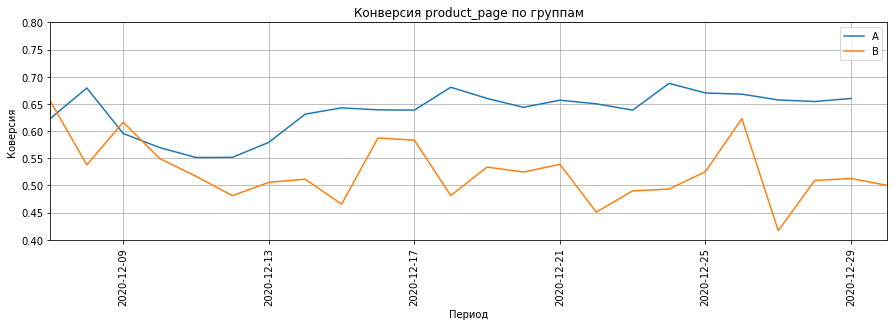

In [44]:
plt.figure(figsize=(15,4))
plt.plot(unique_actions_by_dateA['event_day'], unique_actions_by_dateA['conversion_Product_page'], label='A')
plt.plot(unique_actions_by_dateB['event_day'], unique_actions_by_dateB['conversion_Product_page'], label='B')

plt.axis([unique_actions_by_date['event_day'].min(), unique_actions_by_date['event_day'].max(), 0.4, 0.8]);

plt.title('Конверсия product_page по группам')
plt.xlabel('Период')
plt.ylabel('Коверсия')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend();

### Относительный прирост конверсии product_page по группам<a id='9-link'></a>

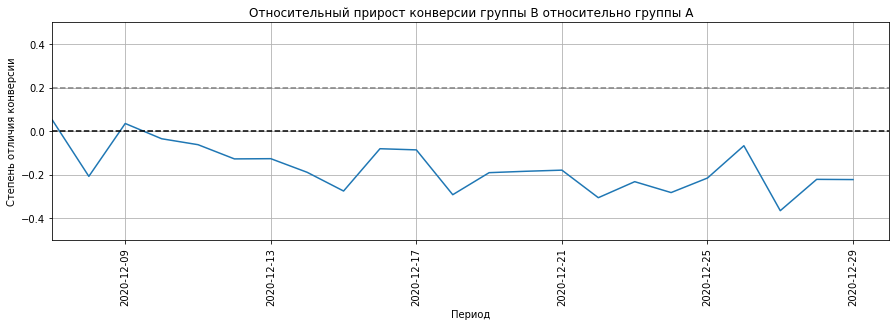

In [45]:
plt.figure(figsize=(15,4))

plt.plot(mergedCumulativeConversions['event_day'], mergedCumulativeConversions['conversion_Product_pageB']/mergedCumulativeConversions['conversion_Product_pageA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([unique_actions_by_dateB['event_day'].min(), unique_actions_by_dateB['event_day'].max(), -0.5, 0.5]);

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Период')
plt.ylabel('Степень отличия конверсии')
plt.xticks(rotation=90)
plt.grid(True)

На графике видно, что начиная с 9.12 конверсия группы А выше

### Конверсия product_cart по группам<a id='10-link'></a>

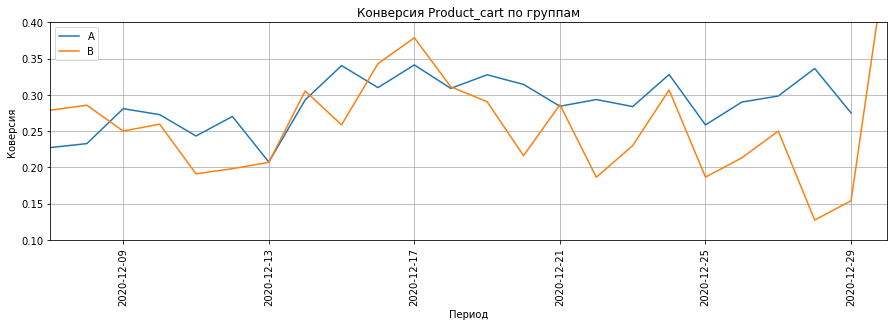

In [46]:
plt.figure(figsize=(15,4))
plt.plot(unique_actions_by_dateA['event_day'], unique_actions_by_dateA['conversion_Product_cart'], label='A')
plt.plot(unique_actions_by_dateB['event_day'], unique_actions_by_dateB['conversion_Product_cart'], label='B')

plt.axis([unique_actions_by_date['event_day'].min(), unique_actions_by_date['event_day'].max(), 0.1, 0.4]);

plt.title('Конверсия Product_cart по группам')
plt.xlabel('Период')
plt.ylabel('Коверсия')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend();

### Относительный прирост конверсии product_cart по группам<a id='11-link'></a>

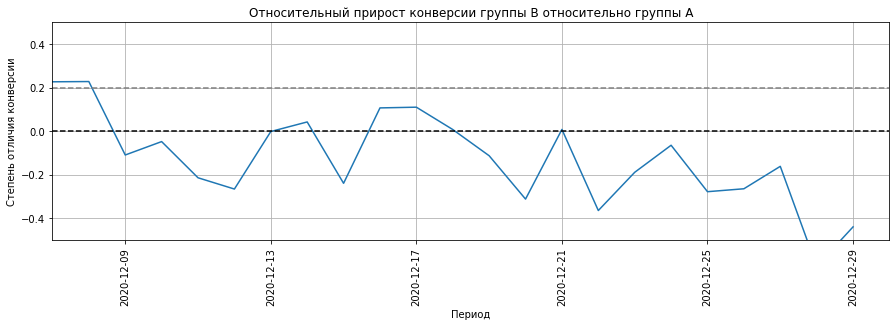

In [47]:
plt.figure(figsize=(15,4))

plt.plot(mergedCumulativeConversions['event_day'], mergedCumulativeConversions['conversion_Product_cartB']/mergedCumulativeConversions['conversion_Product_cartA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([unique_actions_by_dateB['event_day'].min(), unique_actions_by_dateB['event_day'].max(), -0.5, 0.5]);

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Период')
plt.ylabel('Степень отличия конверсии')
plt.xticks(rotation=90)
plt.grid(True)

На графике видно, что конверсия группы А выше, за исключением периода с 16.12 по 18.12

### Конверсия purchase по группам<a id='12-link'></a>

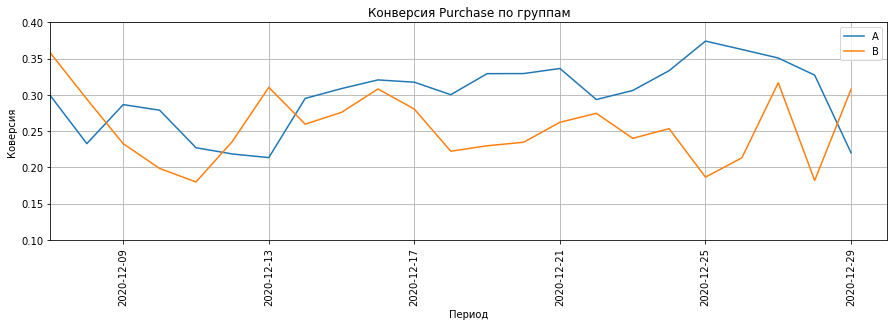

In [48]:
plt.figure(figsize=(15,4))
plt.plot(unique_actions_by_dateA['event_day'], unique_actions_by_dateA['conversion_Purchase'], label='A')
plt.plot(unique_actions_by_dateB['event_day'], unique_actions_by_dateB['conversion_Purchase'], label='B')

plt.axis([unique_actions_by_date['event_day'].min(), unique_actions_by_date['event_day'].max(), 0.1, 0.4]);

plt.title('Конверсия Purchase по группам')
plt.xlabel('Период')
plt.ylabel('Коверсия')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend();

### Относительный прирост конверсии purchase по группам<a id='13-link'></a>

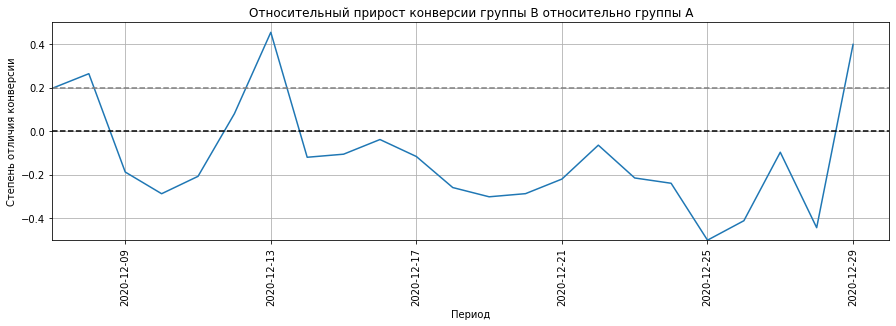

In [49]:
plt.figure(figsize=(15,4))

plt.plot(mergedCumulativeConversions['event_day'], mergedCumulativeConversions['conversion_PurchaseB']/mergedCumulativeConversions['conversion_PurchaseA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([unique_actions_by_dateB['event_day'].min(), unique_actions_by_dateB['event_day'].max(), -0.5, 0.5]);

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Период')
plt.ylabel('Степень отличия конверсии')
plt.xticks(rotation=90)
plt.grid(True)

На графике видно, что конверсия группы А выше, кроме 7, 8, 13 и 29 декабря

Создаем массив уникальных пар значений дат и групп теста для определения кумулятивной выручки

In [50]:
clean_users_purchase = fin_df_v1.query('event_name == "purchase"')

In [51]:
datesGroups = clean_users_purchase.loc[:, ['event_day', 'group']].drop_duplicates()

Объявим переменную purchasesAggregated, агрегированные кумулятивные по дням данные о заказах 

In [52]:
purchasesAggregated = datesGroups.apply(lambda x: clean_users_purchase[np.logical_and(clean_users_purchase['event_day'] <= x['event_day'], clean_users_purchase['group'] == x['group'])]\
.agg({'event_day' : 'max', 'group' : 'max', 'user_id' : pd.Series.nunique, 'details' : 'sum'}), axis=1).sort_values(by=['event_day','group'])

In [53]:
purchasesAggregated.head()

,event_day,group,user_id,details
5,2020-12-07,A,46,1214.54
58,2020-12-07,B,59,704.41
1693,2020-12-08,A,72,1994.17
1700,2020-12-08,B,71,1199.06
3382,2020-12-09,A,95,3363.66


Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и в группе B

In [54]:
cumulativeRevenueA = purchasesAggregated[purchasesAggregated['group']=='A'][['event_day','details', 'user_id']]
cumulativeRevenueB = purchasesAggregated[purchasesAggregated['group']=='B'][['event_day','details', 'user_id']]

### Выручка в разрезе групп<a id='14-link'></a>

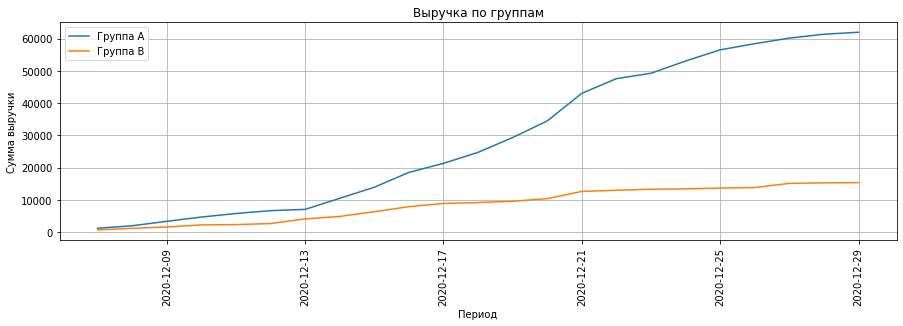

In [55]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15,4))
plt.plot(cumulativeRevenueA['event_day'], cumulativeRevenueA['details'], label='Группа A')
plt.plot(cumulativeRevenueB['event_day'], cumulativeRevenueB['details'], label='Группа B')

plt.title('Выручка по группам')
plt.xlabel('Период')
plt.ylabel('Сумма выручки')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend();

КУмулятивная выручка группы А выше из-за большего количества юзеров, показательнее будет проанализировать средний чек

### Средний чек в разрезе групп<a id='15-link'></a>

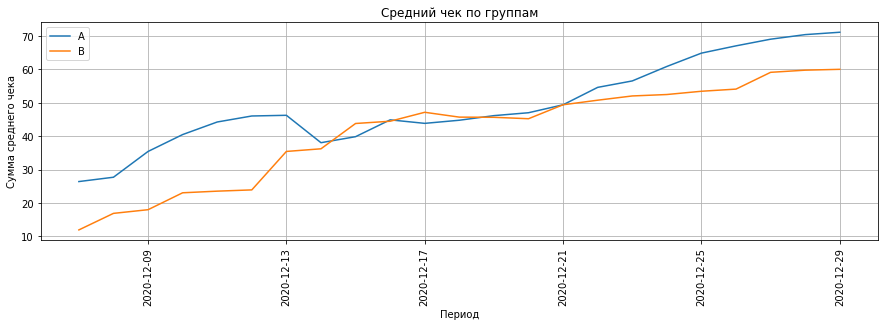

In [56]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeRevenueA['event_day'], cumulativeRevenueA['details']/cumulativeRevenueA['user_id'], label='A')
plt.plot(cumulativeRevenueB['event_day'], cumulativeRevenueB['details']/cumulativeRevenueB['user_id'], label='B')
plt.title('Средний чек по группам')
plt.xlabel('Период')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend();

Объединим данные 2 групп

In [57]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='event_day', right_on='event_day', how='left', suffixes=['A', 'B'])

### Отношение среднего чека групп<a id='16-link'></a>

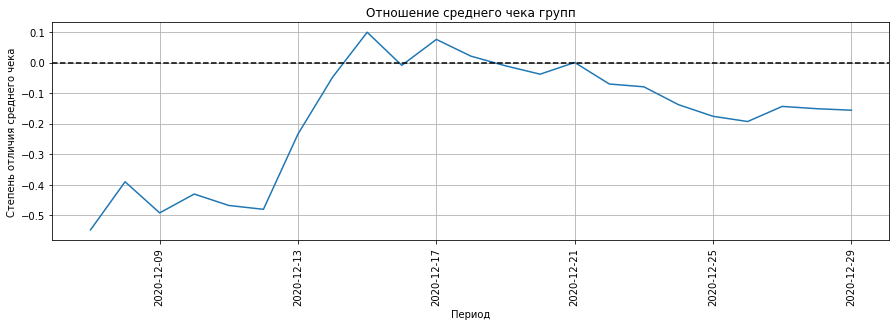

In [58]:
plt.figure(figsize=(15,4))
plt.plot(mergedCumulativeRevenue['event_day'], (mergedCumulativeRevenue['detailsB']/mergedCumulativeRevenue['user_idB'])/(mergedCumulativeRevenue['detailsA']/mergedCumulativeRevenue['user_idA'])-1)
plt.axhline(y=0, color='black', linestyle='--');
plt.title('Отношение среднего чека групп')
plt.xlabel('Период')
plt.ylabel('Степень отличия среднего чека')
plt.xticks(rotation=90)
plt.grid(True)

Средний чек группы А выше на протяжении большей части теста

# Шаг 4. Статистическая значимость различий в конверсии между группами<a id='17-link'></a>

Описанная ниже формула использует как аргументы количественные данные о событиях, совершенных пользователями двух сравниваемых групп, и возвращает значение p_value 

In [59]:
 def stat(event1_g1, event1_g2, event2_g1, event2_g2):
    
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([event1_g1, event1_g2])
    trials = np.array([event2_g1, event2_g2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(p_value)
    
    if (p_value < alpha):
        return "Отвергаем нулевую гипотезу: между долями есть значимая разница"
    else:
        return "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными" 
 

Итоговые данные для теста

In [60]:
unique_actions_by_group = fin_df_v1.pivot_table(index = ['event_name'], columns = 'group', values='user_id', aggfunc='nunique').reset_index()
unique_actions_by_group.head()

group,event_name,A,B
0,login,2747,928
1,product_cart,824,255
2,product_page,1780,523
3,purchase,872,256


product_cart

In [61]:
stat(unique_actions_by_group['A'][1], unique_actions_by_group['B'][1], unique_actions_by_group['A'][0], unique_actions_by_group['B'][0])

0.14534814557238196


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

product_page

In [62]:
stat(unique_actions_by_group['A'][2], unique_actions_by_group['B'][2], unique_actions_by_group['A'][0], unique_actions_by_group['B'][0])

4.310980554755872e-06


'Отвергаем нулевую гипотезу: между долями есть значимая разница'

purchase

In [63]:
stat(unique_actions_by_group['A'][3], unique_actions_by_group['B'][3], unique_actions_by_group['A'][0], unique_actions_by_group['B'][0])

0.017592402663314743


'Отвергаем нулевую гипотезу: между долями есть значимая разница'

# Шаг 5. Вывод<a id='18-link'></a>

В ходе анализа AB тестирования мы рассмотрели показатели конверсии и их динамику между группами, Z тест показал значимое статистическое различие между группами в анализе событий product_page и purchase, что не позволяет нам сделать обоснованный вывод о влиянии рекомендательной системы на эти показатели. Конверсия в product_cart выше у группы А, т.е. группы, в которую не была внедрена новая система.

Изначальные ожидания о наборе данных для тестирования не оправдались, так количество пользователей-участников меньше почти в 2 раза, доля EU пользователей всего 8%. 2 из 3 метрик показали статистически значимые различия. Наиболее рациональным решением будет обновить дизайн теста и провести его в период, не приуроченный к крупным маркетинговым акциям, а также учесть опыт ожиданий от объема новых пользователей.

В зависимости от алгоритма работы рекомендательной системы можно рассмотреть более длительный период теста, т.к. для формирования индивидуальных рекомендаций алгоритму требуется время на обучение, и эффект от его использования может проявиться в течение более длительного периода времени.